In [3]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
from matplotlib.patches import Circle
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit

In [4]:
path = "/data/MIB/anunez/NewSchool/Bolson/Bo_dmo_hydro_h1_SF1/output_00041/"
myhydro = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False)

loading Dark matter..
loading Stars..
loading Gas..


In [3]:
cen = myhydro.dm.Clumps.pos3d[myhydro.dm.Clumps.cell==myhydro.dm.Clumps.cell.max()]
myhydro.center_shift(cen)

In [5]:
myhydro.st.age.min()

-0.94064325

In [4]:
myhydro.r_virial(600)

| r_200 = 215.0390625
---- taking particles inside 2.5 * r200
min -536.429786237, max 536.761716656
| number of praticles inside 2.5 * r200 
| dm mass       =  1.30021772493e+12 M_sun
| p_dm_200      =  825909 particles
| stellar mass  =  39935217664.0 M_sun
| p_st_200      =  1579362 psrticles
| gas mass      =  1.96659298304e+11 M_sun
| p_gs_200      =  2431393 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |16,0,0|
| D =|0,11,0|
|    |0,0,1|


In [5]:
ok,rho_dm,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),
                                    dtype=np.float32), myhydro.dm.mass)


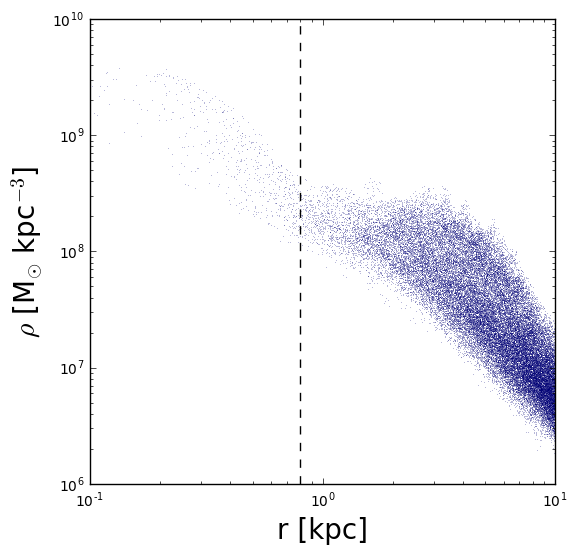

In [6]:
fig, ax = plt.subplots(figsize=[6,6])
r_ball = np.copy(myhydro.dm.r)
ax.scatter(myhydro.dm.r, rho_dm,s=0.1,lw=0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1e-1,1e1])
ax.set_ylim([1e6,1e10])
y = np.logspace(6,11,15)
x = np.array([0.8 for i in y])
ax.plot(x,y,"k--")
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)

In [7]:
center = nbe.real_center(myhydro.st.pos3d, myhydro.st.mass)
myhydro.center_shift(center)
myhydro.redefine(5)

min -505.133839529, max 525.989128918
min -536.098174353, max 536.49256167


In [8]:
ok,rho_dm,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),
                                    dtype=np.float32), myhydro.dm.mass)

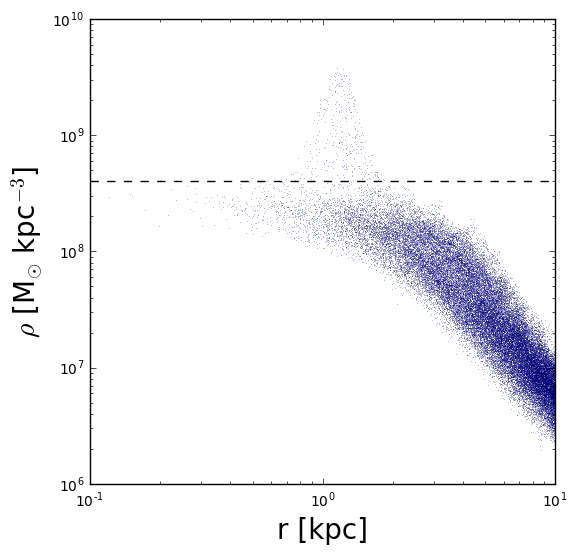

In [9]:
fig, ax = plt.subplots(figsize=[6,6])
r_ball = np.copy(myhydro.dm.r)
ax.scatter(myhydro.dm.r, rho_dm,s=0.1,lw=0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1e-1,1e1])
ax.set_ylim([1e6,1e10])

x = np.logspace(-1,1.1,15)
y = np.array([4e8 for i in y])
ax.plot(x,y,"k--")
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)

In [11]:
ball_id = myhydro.dm.id[np.where(rho_dm>4e8)]
ball_id = np.copy(ball_id)
index = np.where(np.in1d(myhydro.dm.id,ball_id))
print len(index[0])

388


In [11]:
ball_id = np.copy(ball_id)

In [132]:
path = "/data/MIB/anunez/NewSchool/Bolson/Bo_dmo_hydro_h1_SF1/output_00008/"
myhydro = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False,comov=True)

loading Dark matter..
loading Stars..
loading Gas..


388
[ 7.83105469 -2.92675781 -1.37597656]
6.10352e-05 70598744.0


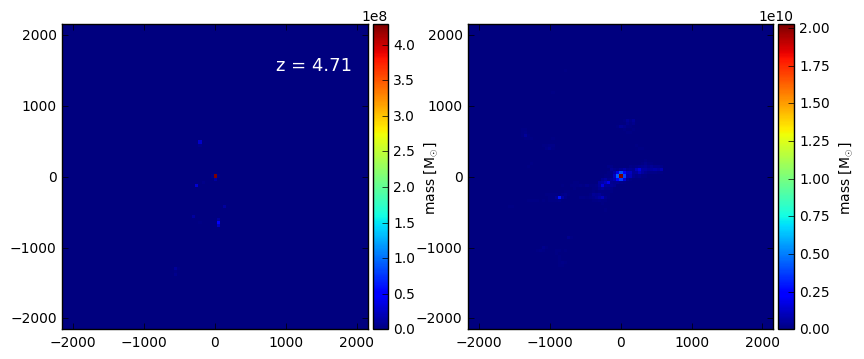

In [133]:
index = np.where(np.in1d(myhydro.dm.id,ball_id))
pos = np.copy(myhydro.dm.pos3d[index])
mass = myhydro.dm.mass[index]
r= np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
ok,rho_b,_= CF.getDensity(np.array(pos.reshape(len(pos)*3),
                                    dtype=np.float32), mass)
print len(rho_b)

cen = pos[np.where(rho_b==rho_b.max())]#nbe.real_center(pos, mass,n=len(mass)/10)
print cen[0]
pos = pos - cen[0] 
myhydro.center_shift(cen[0])
print myhydro.gs.hsml.min(),2*r.max()/myhydro.gs.hsml.min()
edges = np.linspace(-r.max(),r.max(),100)
x ,y, z = pos[:,0],pos[:,1],pos[:,2]
H, xedges, yedges = np.histogram2d(x, z, bins=(edges, edges),
                                   weights=mass)
ball = H.T

x ,y, z = myhydro.dm.pos3d[:,0],myhydro.dm.pos3d[:,1],myhydro.dm.pos3d[:,2]
filt = (myhydro.dm.mass == myhydro.dm.mass.min())&(np.abs(y)<50)
H, xedges, yedges = np.histogram2d(x[filt], z[filt], bins=(edges, edges),
                                   weights=myhydro.dm.mass[filt])
everything = H.T

fig,[ax,ax1] = plt.subplots(1,2,figsize=[8,4])
plt.tight_layout(w_pad=3)
mass_1 = ax.imshow(ball, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

mass_1 = ax1.imshow(everything,interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')
texto = "z = {0:.2f}".format((1./myhydro.p.aexp)-1)
ax.text(r.max()*0.4,r.max()*0.7,texto,color='w',fontsize=13)
#ax1.scatter(pos[:,0],pos[:,2],s=0.1,lw=0)


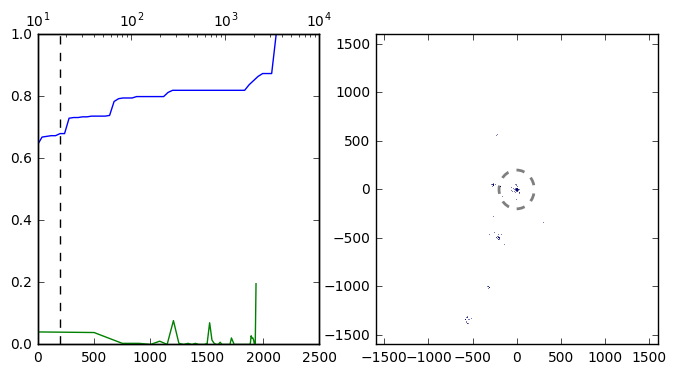

In [134]:
r= np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)

hist, bins = np.histogram(r,bins=np.linspace(0,r.max(),55),weights=mass)
cum = np.cumsum(hist) /np.sum(hist)
fig, [ax,ax1] = plt.subplots(1,2,figsize=[8,4])
ax2 = ax.twiny()
ax2.set_xscale('log')
ax.plot(bins[:-1],cum)
ax2.plot(bins[:-1],hist/hist.max(),c='g')

y = np.arange(0,1.1,0.1)
sigma =  bins[np.argmin(np.abs(cum-0.68))]
x = np.array([sigma for i in y])
ax.plot(x,y,'k--')
ax1.set_xlim([-8*sigma,8*sigma])
ax1.set_ylim([-8*sigma,8*sigma])

ax1.scatter(pos[:,0],pos[:,1],s=0.2,lw=0)
ax1.add_artist(Circle(xy=(0, 0), 
                  radius=sigma,alpha=0.5,fc='none',lw=2,ls='--'))

-1743.8 628.9


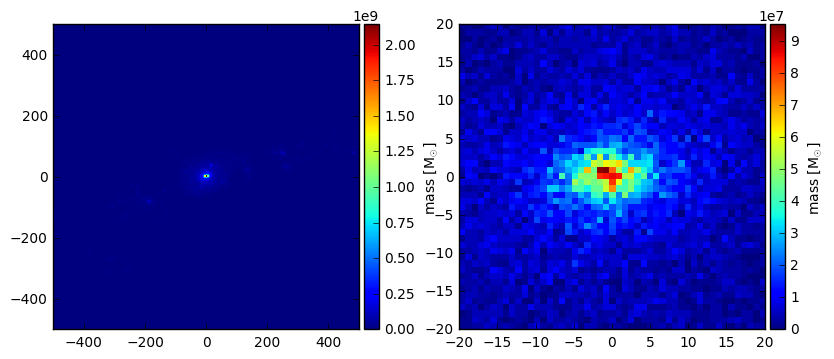

In [135]:
thikness = 40
super_filter = (myhydro.dm.mass==myhydro.dm.mass.min())&(np.abs(myhydro.dm.pos3d[:,1])<thikness)
slice_pos = myhydro.dm.pos3d[super_filter]
slice_mass = myhydro.dm.mass[super_filter]
print slice_pos[:,0].min(),slice_pos[:,0].max()
edges = np.linspace(-500,500,200)
x ,y, z = slice_pos[:,0],slice_pos[:,1],slice_pos[:,2]
H, xedges, yedges = np.histogram2d(x, z, bins=(edges, edges),
                                   weights=slice_mass)

slice_hist = H.T

edges2 = np.linspace(-20,20,50)
H, xedges, yedges = np.histogram2d(x, z, bins=(edges2, edges2),
                                   weights=slice_mass)

zoom = H.T

fig,[ax,ax1] = plt.subplots(1,2,figsize=[8,4])
plt.tight_layout(w_pad=3)
mass_1 = ax.imshow(slice_hist, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])#,vmax=5e7)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')
#texto = "z = {0:.2f}".format((1./myhydro.p.aexp)-1)
#ax.text(1000,slice_pos[:,2].min()*7/10,texto,color='w',fontsize=13)

mass_1 = ax1.imshow(zoom, interpolation='nearest', origin='low',
                       extent=[edges2[0], edges2[-1], edges2[0], edges2[-1]])#,vmax=1e8)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')


In [136]:
lagrangian = (myhydro.dm.mass==myhydro.dm.mass.min())
lagra_pos = myhydro.dm.pos3d[lagrangian]
lagra_mass = myhydro.dm.mass[lagrangian] 
ok,rho_lagra,_= CF.getDensity(np.array(lagra_pos.reshape(len(lagra_pos)*3),
                                    dtype=np.float32), lagra_mass)


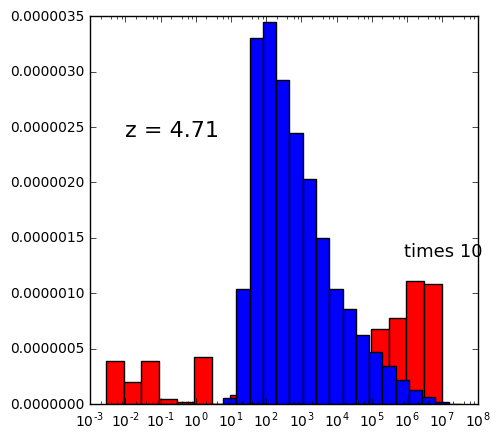

In [137]:
hist, bins = np.histogram(rho_lagra,bins=np.logspace(np.log10(rho_lagra.min()),np.log10(rho_lagra.max()),20),normed=True)
hist_b, bins_b= np.histogram(rho_b,bins=np.logspace(np.log10(rho_b.min()),np.log10(rho_b.max()),20),normed=True)

fig , ax = plt.subplots(figsize=[5,5])
ax.set_xscale('log')

#ax.set_yscale('log')
factor= 10
ax.bar(bins_b[1:],factor*hist_b,width=(bins_b[:-1]-bins_b[1:]),color='r')
ax.bar(bins[1:],hist,width=bins[:-1]-bins[1:])
ax.text(1e-2,hist.max()*0.7,texto,fontsize=16)
ax.text(np.mean(bins_b)*1.2,1.2*factor*hist_b.max(),"times {0}".format(factor),fontsize=13)

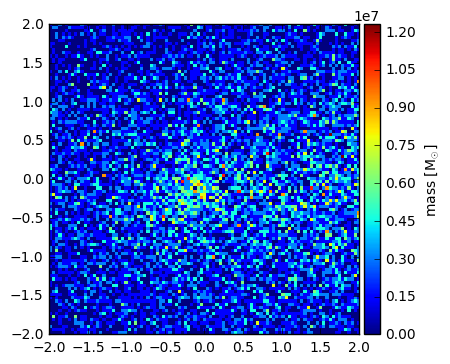

In [11]:
pos = myhydro.dm.pos3d[myhydro.dm.mass==myhydro.dm.mass.min()]
mass = myhydro.dm.mass[myhydro.dm.mass==myhydro.dm.mass.min()]
edges = np.linspace(-2,2,100)
x ,y, z = pos[:,0],pos[:,1],pos[:,2]



H, xedges, yedges = np.histogram2d(x, z, bins=(edges, edges),
                                   weights=mass)
dm_faceon = H.T

fig,ax = plt.subplots()
mass_1 = ax.imshow(dm_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')


In [40]:
path = "/data/MIB/anunez/NewSchool/Bolson/Bo_dmo_hydro_h1_SF1/output_00002"
myhydro = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False,comov=True)

loading Dark matter..
loading Stars..
loading Gas..


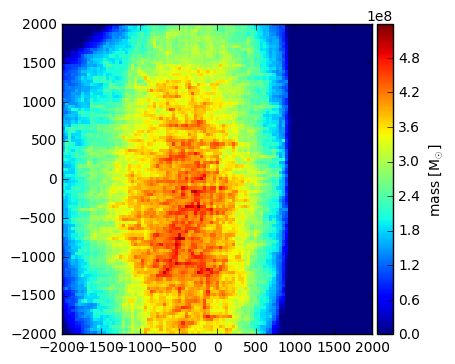

In [43]:
pos = myhydro.dm.pos3d[myhydro.dm.mass==myhydro.dm.mass.min()]
mass = myhydro.dm.mass[myhydro.dm.mass==myhydro.dm.mass.min()]
edges = np.linspace(-2000,2000,100)
x ,y, z = pos[:,0],pos[:,1],pos[:,2]



H, xedges, yedges = np.histogram2d(x, z, bins=(edges, edges),
                                   weights=mass)
dm_faceon = H.T

fig,ax = plt.subplots()
mass_1 = ax.imshow(dm_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')



In [52]:
path = "/data/MIB/anunez/NewSchool/Bolson/Bo_dmo_hydro_h1_SF1/output_00003"
myhydro = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False,comov=True)

loading Dark matter..
loading Stars..
loading Gas..


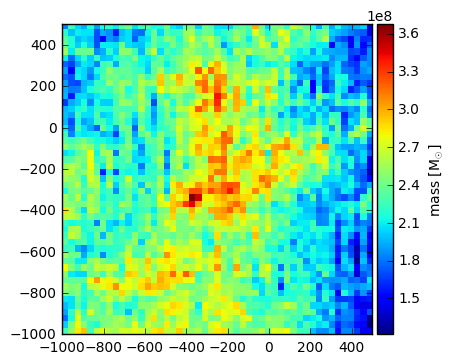

In [53]:

pos = myhydro.dm.pos3d[myhydro.dm.mass==myhydro.dm.mass.min()]
mass = myhydro.dm.mass[myhydro.dm.mass==myhydro.dm.mass.min()]
edges = np.linspace(-1000,500,50)
x ,y, z = pos[:,0],pos[:,1],pos[:,2]



H, xedges, yedges = np.histogram2d(x, z, bins=(edges, edges),
                                   weights=mass)
dm_faceon = H.T

fig,ax = plt.subplots()
mass_1 = ax.imshow(dm_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')



In [54]:
path = "/data/MIB/anunez/NewSchool/Bolson/Bo_dmo_hydro_h1_SF1/output_00004"
myhydro = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False,comov=True)

loading Dark matter..
loading Stars..
loading Gas..


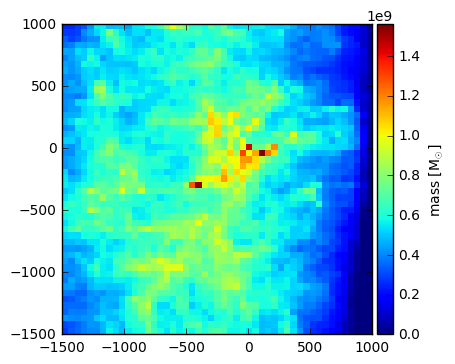

In [64]:
pos = myhydro.dm.pos3d[myhydro.dm.mass==myhydro.dm.mass.min()]
mass = myhydro.dm.mass[myhydro.dm.mass==myhydro.dm.mass.min()]
edges = np.linspace(-1500,1000,50)
x ,y, z = pos[:,0],pos[:,1],pos[:,2]



H, xedges, yedges = np.histogram2d(x, z, bins=(edges, edges),
                                   weights=mass)
dm_faceon = H.T

fig,ax = plt.subplots()
mass_1 = ax.imshow(dm_faceon, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')
